In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

### Load and prepare data

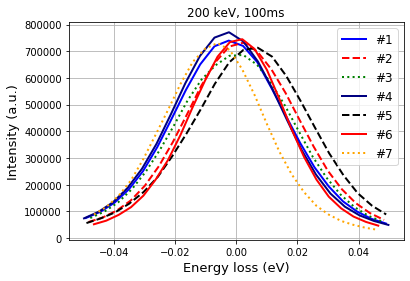

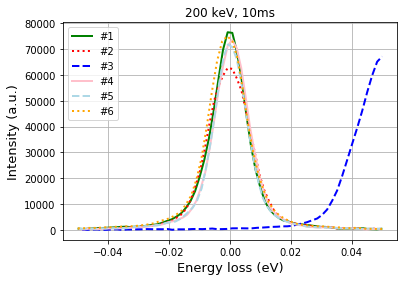


 ************************ Data files have been prepared ***************************** 

Seed number for this set is: 23


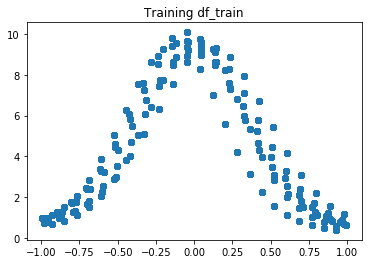

In [117]:
mode = 'Mixture'
%run EELS-ZLP-Mar.py

seed = seednumber


### Find uncertainties on data

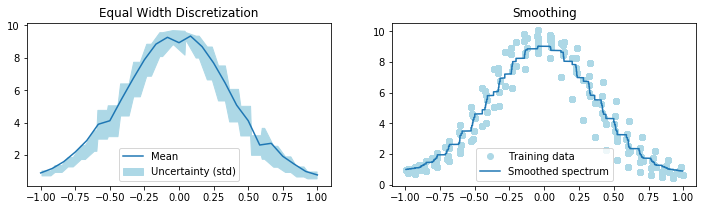

In [118]:
%run Functions.ipynb
fig = plt.gcf()
from copy import copy

nbins = 25
minval = -1
maxval = +1

if mode == 'Mixture':
    x_train, y_train, x_val, y_val = prepare_mix_data(100)
if mode == 'Single':
    x_train, y_train = prepare_single_data()

# Create a plot of the mean & std 
plt.subplot(1, 2, 1)
plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.title('Equal Width Discretization')
fig.set_size_inches(12, 5)

# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
#create one vector with (x_train, y_train, sigma_train)
df_train = np.c_[df_train, variance_vector_t]

# Store output vectors for validation
df_val, cuts1_v, cuts2_v = ewd(x_val, y_val)
mean_v, std_v, count_v= binned_statistics(x_val, y_val)
variance_vector_v = vectorize_variance(x_val, y_val)
mean_vector_v = vectorize_mean(x_val, y_val)
#create one vector with (x_train, y_train, sigma_train)
df_val = np.c_[df_val, variance_vector_v]


### Apply smoothing to the signal
smooth_y = np.array(smooth(df_train[:,1], 400))
smooth_y_test = np.array(smooth(df_val[:,1], 400))
plt.subplot(1,2,2)
plt.plot(df_train[:,0], df_train[:,1], 'o', color='lightblue', label='Training data')
plt.plot(df_train[:,0], smooth_y, label='Smoothed spectrum')
fig.set_size_inches(12,3)
plt.title('Smoothing')
plt.legend()
plt.show()




## Neural Network 

### Create architecture

In [119]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(inputs, 5, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 5, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    #hidden_layer_4 = tf.nn.dropout(hidden_layer_3, 0.1)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output

# User defined Neural Network


### Prepare data for training

Example of one training x, shape (,2): [-0.8992915  1.       ]
Example of one training y, shape (,1): [1.21128324]


StandardScaler(copy=True, with_mean=True, with_std=True)

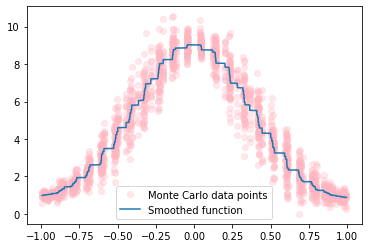

In [125]:
tf.reset_default_graph()
from copy import copy

x = tf.placeholder("float", [None, 2])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

N_train = len(df_train[:,0])
N_test = len(df_val[:,0])
train_x = add_time(df_train, 100)
train_y = copy(smooth_y).reshape(N_train,1)  ## train_y = smooth_y in case of smoothing
train_sigma = df_train[:,2].reshape(N_train,1)
train_y +=  np.random.normal(0, train_sigma) # Create Monte Carlo points

test_x = add_time(df_val, 100)
test_y = copy(smooth_y_test).reshape(N_test,1)
test_sigma = df_val[:,2].reshape(N_test,1)
test_y +=  np.random.normal(0, test_sigma) # Create Monte Carlo points

predictions = make_model(x,1)

    ### Define cost and optimizer

cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
eta = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08, ).minimize(cost)

plt.plot(train_x[:,0], train_y, 'o', alpha=.3, color='lightpink', label='Monte Carlo data points')
plt.plot(train_x[:,0], smooth_y, label='Smoothed function')
plt.legend()
plt.show

print("Example of one training x, shape (,2):", train_x[80,:])
print("Example of one training y, shape (,1):", train_y[80])

# Scaling input features to help the minimizer.
train_scaler = StandardScaler()
train_scaler.fit(train_x[:,0].reshape(1,-1))
test_scaler = StandardScaler()
test_scaler.fit(test_x[:,0].reshape(1,-1))



### Train and validate

In [128]:
training_epochs = 30000
max_rising_epochs = 20000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 1000
prev_test_cost = 100
prev_epoch=0
avg_cost = 0.0

x_predict = 2 * copy(train_x)
x_predict[:,1] = 1/2 * x_predict[:,1]
array_train = []
array_test = []
print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(training_epochs):
        
        _, c = sess.run([optimizer, cost], 
                        feed_dict={
                            x: train_x,
                            y: train_y,
                            sigma: train_sigma
                        })
        avg_cost = c 
        
        test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})
        
        
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
            array_train.append(avg_cost)
            array_test.append(test_cost)
                         
        if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
            print(colored("\n The session stopped because of overfitting...","red"))
            print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
            break
        
            
        elif test_cost < prev_test_cost:
            prev_test_cost = test_cost
            prev_epoch = epoch
        
    
    print("Optimization Finished!")
    predictions_values = sess.run(predictions, 
                        feed_dict={
                            x: x_predict,
                            y: train_y 
                        })
sess.close()
    


Start training on 1796 and validating on 0450 samples
Epoch: 0001 | Training cost= 105.341087341 | Validation cost= 111.181999207
Epoch: 1001 | Training cost= 52.765575409 | Validation cost= 25.715515137
Epoch: 2001 | Training cost= 9.225987434 | Validation cost= 8.698601723
Epoch: 3001 | Training cost= 1.037385106 | Validation cost= 14.540344238
Epoch: 4001 | Training cost= 1.001129150 | Validation cost= 14.682138443
Epoch: 5001 | Training cost= 0.997062385 | Validation cost= 14.686317444
Epoch: 6001 | Training cost= 0.994838595 | Validation cost= 14.674889565
Epoch: 7001 | Training cost= 0.993593156 | Validation cost= 14.663939476
Epoch: 8001 | Training cost= 0.993189394 | Validation cost= 14.658688545
Epoch: 9001 | Training cost= 0.992950380 | Validation cost= 14.653283119
Epoch: 10001 | Training cost= 0.992646098 | Validation cost= 14.658689499
Epoch: 11001 | Training cost= 0.992342353 | Validation cost= 14.667998314
Epoch: 12001 | Training cost= 0.991908550 | Validation cost= 14.6

### Plot outputs

In [129]:
# save to csv file
from datetime import datetime
predictions_values = predictions_values.reshape(N_train,)

#foot = np.array(seednumber)
a = np.array(train_x[:,0])
b = np.array(train_y)
c = np.array(predictions_values)
d = array_train
e = array_test

now = datetime.now()
dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
np.savetxt('Data/Results/%(date)s.%(seed)x(a).csv' % {"date": dt_string, "seed":seed}, list(zip(a,b,c)),  delimiter=',',  header="Training inputs, Training outputs, Predictions", fmt='%f')
np.savetxt('Data/Results/%(date)s.%(seed)x(b).csv' % {"date": dt_string, "seed":seed}, list(zip(d,e)),  delimiter=',',  header="Chi2_train, Chi2_test", fmt='%f')


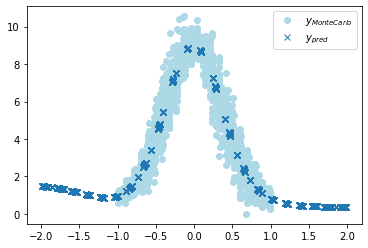

In [132]:
plt.plot(train_x[:,0], train_y, 'o', label='$y_{MonteCarlo}$', color='lightblue')
plt.plot(x_predict[:,0], predictions_values, 'x', label='$y_{pred}$')
#plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.legend()
plt.show()

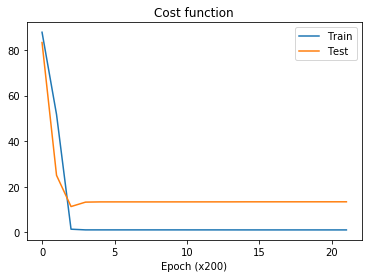

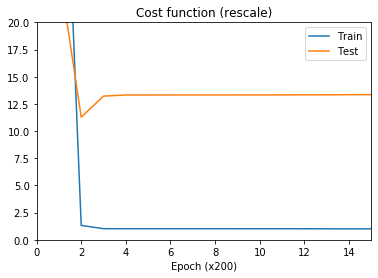

In [106]:
plt.plot(array_train, label='Train')
plt.plot(array_test, label='Test')
plt.title('Cost function')
plt.xlabel('Epoch (x200)')
plt.savefig('Figures/Cost function')
#plt.xlim([1,30])
#plt.ylim([0,100])
plt.legend()
plt.show()

plt.plot(array_train, label='Train')
plt.plot(array_test, label='Test')
plt.title('Cost function (rescale)')
plt.xlabel('Epoch (x200)')
plt.savefig('Figures/Cost function (rescale)')
plt.ylim([0,20])
plt.xlim([0,15])
plt.legend()
plt.show()

